In [1]:
# Setup Cell (Install Libraries)

# Install required packages
!pip install networkx python-louvain matplotlib pandas numpy tqdm

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     --- --------------------------------- 20.5/204.6 kB 131.3 kB/s eta 0:00:02
     --- --------------------------------- 20.5/204.6 kB 131.3 kB/s eta 0:00:02
     ----- ------------------------------- 30.7/204.6 kB 108.9 kB/s eta 0:00:02
     ----- ------------------------------- 30.7/204.6 kB 108.9 kB/s eta 0:00:02
     ------- ----------------------------- 41.0/204.6 kB 122.9 kB/s eta 0:00:02
     ----------- ------------------------- 61.4/204.6 kB 163.6 kB/s eta 0:00:01
     ------------ ------------------------ 71.7/204.6 kB 170.7 kB/s eta 0:00:01
     ------------------- ---------------- 112.6/204.6 kB 242.7 kB/s eta 0:00:01
     ------------------------- ---------- 143.4/204.6 kB 283.8 kB/s eta 0:00:01
     ---------------------------------- - 194.6/204.6 kB 346

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

#### Loading & Inspecting the Network Dataset Properly

In [11]:
# Load the edge list from the file
G = nx.read_edgelist("facebook_combined.txt.gz", create_using=nx.Graph(), nodetype=int)

# Basic inspection
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Check if graph is connected
print("Is the graph fully connected?", nx.is_connected(G))

# Find number of connected components
print("Number of connected components:", nx.number_connected_components(G))

# Inspect the first 10 nodes and their degrees
degrees = dict(G.degree())
top10 = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 highest-degree nodes:", top10)


Number of nodes: 4039
Number of edges: 88234
Is the graph fully connected? True
Number of connected components: 1
Top 10 highest-degree nodes: [(107, 1045), (1684, 792), (1912, 755), (3437, 547), (0, 347), (2543, 294), (2347, 291), (1888, 254), (1800, 245), (1663, 235)]


#### Preprocessing and Graph Enhancement

In [14]:
# Ensure graph is undirected and simple
G = nx.Graph(G)

# Create adjacency matrix if needed later
A = nx.adjacency_matrix(G)

# Compute basic metrics for reuse
degrees = dict(G.degree())
bet = nx.betweenness_centrality(G, k=300, normalized=True, seed=42)  # sample for speed
eig = nx.eigenvector_centrality(G, max_iter=1000)

clustering = nx.clustering(G)
triangles = nx.triangles(G)

# Identify largest connected component (even though graph is fully connected)
LCC = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(LCC).copy()

print("Graph preprocessed successfully.")
print("Nodes in largest component:", len(G_lcc))


Graph preprocessed successfully.
Nodes in largest component: 4039


In [16]:
!pip install python-louvain

import community as community_louvain


### RQ1 — Community Structure & Role Analogy
How does the network naturally partition into communities, and can these structural clusters be 
interpreted as role-based groups (e.g., students, teachers, admins, parents) within a school 
ecosystem using only network topology?

Methods: Louvain modularity, visual cluster mapping, cluster size/compactness analysis.


#### Louvain Community Detection
Louvain is the state-of-the-art method for large social graphs.
It will give:
- number of communities
- size of each community
- modularity (how strongly the network naturally clusters)

In [18]:
# --- Run Louvain ---
print("Running Louvain community detection...")

partition = community_louvain.best_partition(G_lcc, random_state=42)

# modularity
mod = community_louvain.modularity(partition, G_lcc)

# number of communities
num_communities = len(set(partition.values()))

# compute sizes
from collections import Counter
community_sizes = Counter(partition.values())

print("\n=== LOUVAIN RESULTS ===")
print("Number of communities:", num_communities)
print("Modularity:", round(mod, 4))
print("\nTop 10 community sizes:")
for com, size in community_sizes.most_common(10):
    print(f"Community {com}: {size} nodes")

# store partition for next steps
partition_louvain = partition
community_sizes_louvain = community_sizes
modularity_louvain = mod


Running Louvain community detection...

=== LOUVAIN RESULTS ===
Number of communities: 15
Modularity: 0.8349

Top 10 community sizes:
Community 10: 548 nodes
Community 2: 535 nodes
Community 4: 442 nodes
Community 9: 432 nodes
Community 1: 430 nodes
Community 0: 354 nodes
Community 6: 323 nodes
Community 12: 237 nodes
Community 8: 226 nodes
Community 5: 206 nodes


#### Community Visualization

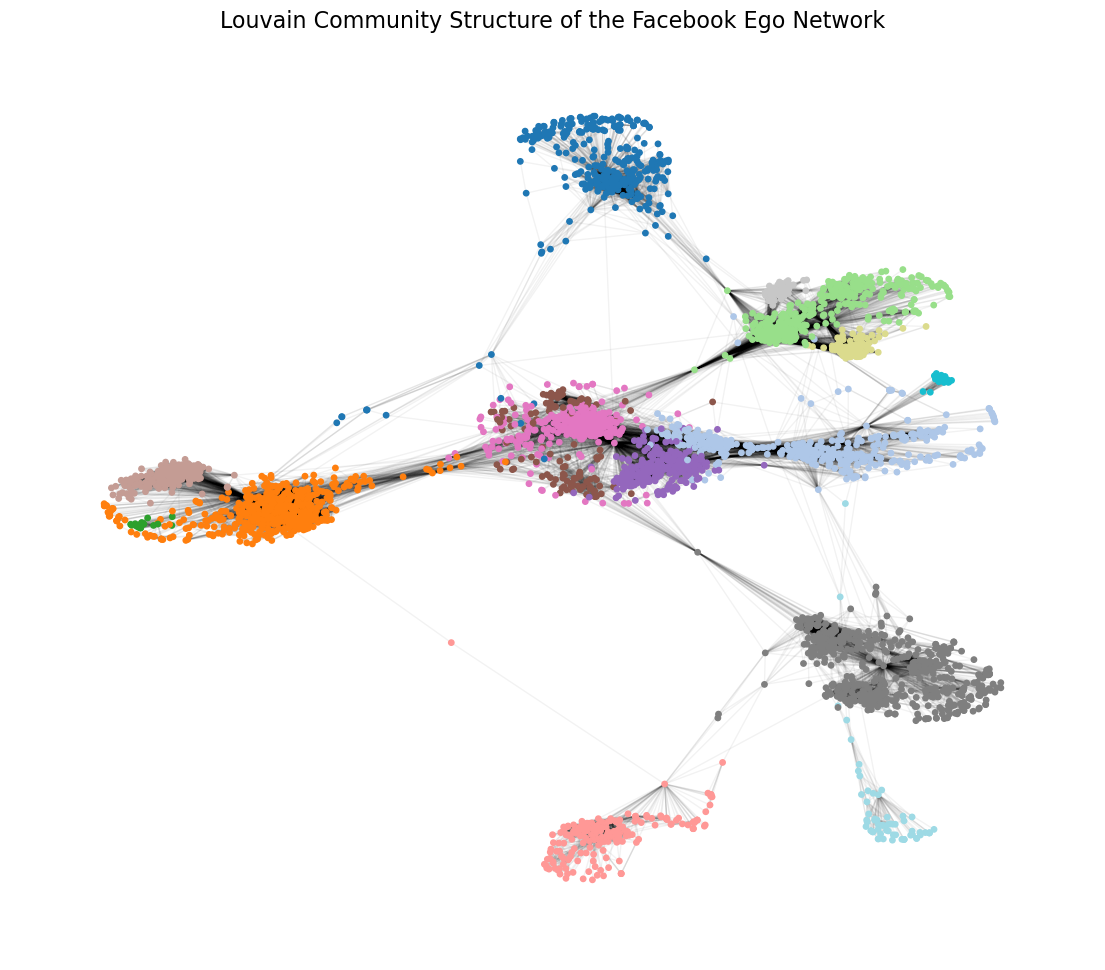

In [21]:
# use spring layout (slow but best visual)
pos = nx.spring_layout(G_lcc, seed=42)

# color map for each community
communities = partition_louvain
colors = [communities[node] for node in G_lcc.nodes()]

plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G_lcc, pos, node_size=15, node_color=colors, cmap="tab20")
nx.draw_networkx_edges(G_lcc, pos, alpha=0.05)

plt.title("Louvain Community Structure of the Facebook Ego Network", fontsize=16)
plt.axis("off")
plt.show()


#### COMMUNITY INTERPRETATION & ROLE MAPPING
The goal is to interpret what each community means and begin connecting the structure
of this social network to the SchoolBase Platform.

In [23]:
from collections import Counter, defaultdict

# Count members per community
comm_counts = Counter(partition_louvain.values())

print("=== Community Sizes ===")
for comm, size in comm_counts.most_common():
    print(f"Community {comm}: {size} nodes")

# reverse mapping: community → list of nodes
community_nodes = defaultdict(list)
for node, comm in partition_louvain.items():
    community_nodes[comm].append(node)

=== Community Sizes ===
Community 10: 548 nodes
Community 2: 535 nodes
Community 4: 442 nodes
Community 9: 432 nodes
Community 1: 430 nodes
Community 0: 354 nodes
Community 6: 323 nodes
Community 12: 237 nodes
Community 8: 226 nodes
Community 5: 206 nodes
Community 7: 128 nodes
Community 11: 73 nodes
Community 14: 61 nodes
Community 13: 25 nodes
Community 3: 19 nodes


### RQ2 — Influence Dynamics & Brokerage
Which nodes act as information brokers or structural bridges, and what does this reveal 
about potential communication hubs (e.g., teachers, school admins) in a digital school platform?

Methods & rationale (concise)
- Betweenness centrality—identifies nodes that sit on many shortest paths (classic “broker”/gatekeeper).
- Eigenvector centrality & degree—help separate local hubs (high degree) from globally influential nodes (eigenvector).
- Community-bridge score—counts how many distinct communities a node’s neighbors belong to; high values → cross-community connector.
- Articulation points—nodes whose removal increases the number of connected components.
- Targeted removal simulation—remove top-k nodes by metric and track LCC size to quantify vulnerability.

In [25]:
# ------- PREP: imports (if not already) -------
import numpy as np
import pandas as pd
# optional: tqdm for progress bars
from tqdm import tqdm

# ------- 1. Centrality computations -------
# If betweenness was computed earlier with sampling k=300, you can reuse.
# Otherwise compute approximate betweenness (k=300) for speed on this graph:
bet = nx.betweenness_centrality(G, k=300, normalized=True, seed=42)   # approx
deg = dict(G.degree())
eig = nx.eigenvector_centrality_numpy(G)  # deterministic and fast for this size

# assemble dataframe
nodes_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [deg[n] for n in G.nodes()],
    'betweenness': [bet[n] for n in G.nodes()],
    'eigenvector': [eig[n] for n in G.nodes()],
})

# ------- 2. Community-bridge score -------
# 'partition' should be dict node->community from Louvain run
# If your partition variable is named differently, adjust.
community_of = partition   # dict: node -> community id

# compute neighbor community set size
def neighbor_communities_count(node):
    neigh = G[node]
    comms = set(community_of.get(int(n), -1) for n in neigh)
    # exclude node's own community?
    return len(comms)

nodes_df['community_id'] = nodes_df['node'].map(community_of)
nodes_df['neighbor_community_count'] = nodes_df['node'].apply(neighbor_communities_count)

# also compute 'bridge_score' normalized by degree (higher = more cross-community per neighbor)
nodes_df['bridge_score'] = nodes_df['neighbor_community_count'] / (nodes_df['degree'].replace(0,1))

# ------- 3. Articulation points (exact) -------
artic_pts = list(nx.articulation_points(G))
nodes_df['articulation'] = nodes_df['node'].isin(artic_pts)

# ------- 4. Top brokers (combine metrics) -------
# define a simple composite broker metric: normalized betweenness + normalized bridge_score
nodes_df['bet_norm'] = (nodes_df['betweenness'] - nodes_df['betweenness'].min()) / (nodes_df['betweenness'].max() - nodes_df['betweenness'].min()+1e-12)
nodes_df['bridge_norm'] = (nodes_df['bridge_score'] - nodes_df['bridge_score'].min()) / (nodes_df['bridge_score'].max() - nodes_df['bridge_score'].min()+1e-12)
nodes_df['broker_rank'] = 0.6*nodes_df['bet_norm'] + 0.4*nodes_df['bridge_norm']  # weights: betweenness prioritized

top_brokers = nodes_df.sort_values('broker_rank', ascending=False).head(30)
top_brokers[['node','degree','betweenness','neighbor_community_count','bridge_score','articulation','broker_rank']].head(20)


,node,degree,betweenness,neighbor_community_count,bridge_score,articulation,broker_rank
107,107,1045,0.484319,8,0.007656,True,0.601250
2006,860,2,0.054310,2,1.000000,False,0.467282
351,1684,792,0.345553,6,0.007576,True,0.429308
1696,550,1,0.000000,1,1.000000,False,0.400000
1837,692,1,0.000000,1,1.000000,False,0.400000
74,74,1,0.000000,1,1.000000,False,0.400000
1175,1690,2,0.000000,2,1.000000,False,0.400000
1808,668,1,0.000000,1,1.000000,False,0.400000
1812,674,1,0.000000,1,1.000000,False,0.400000
631,1145,1,0.000000,1,1.000000,False,0.400000


#### Broker Ranking

In [27]:
# === FIX BROKER METRIC ===

df = nodes_df.copy()

# 1. Remove leaf nodes (degree < 3)
df = df[df['degree'] >= 3].copy()

# 2. Recompute normalized metrics
df['bet_norm'] = (df['betweenness'] - df['betweenness'].min()) / (df['betweenness'].max() - df['betweenness'].min() + 1e-12)
df['comm_norm'] = (df['neighbor_community_count'] - df['neighbor_community_count'].min()) / (df['neighbor_community_count'].max() - df['neighbor_community_count'].min() + 1e-12)

# 3. New broker ranking
df['broker_rank'] = 0.7*df['bet_norm'] + 0.3*df['comm_norm']

# 4. Extract top 20 brokers
top_brokers_fixed = df.sort_values('broker_rank', ascending=False).head(20)

top_brokers_fixed[['node','degree','betweenness','neighbor_community_count','articulation','broker_rank']]


,node,degree,betweenness,neighbor_community_count,articulation,broker_rank
107,107,1045,0.484319,8,True,1.000000
351,1684,792,0.345553,6,True,0.713724
352,1912,755,0.232428,5,True,0.507364
1821,3437,547,0.228416,3,True,0.415850
571,1085,66,0.151117,5,False,0.389843
0,0,347,0.143842,4,True,0.336471
371,563,91,0.058183,6,False,0.298379
350,428,115,0.062570,5,False,0.261862
58,58,12,0.086150,4,False,0.253087
349,414,159,0.040675,5,True,0.230218


#### Visual Bridge-Analysis Scatterplot

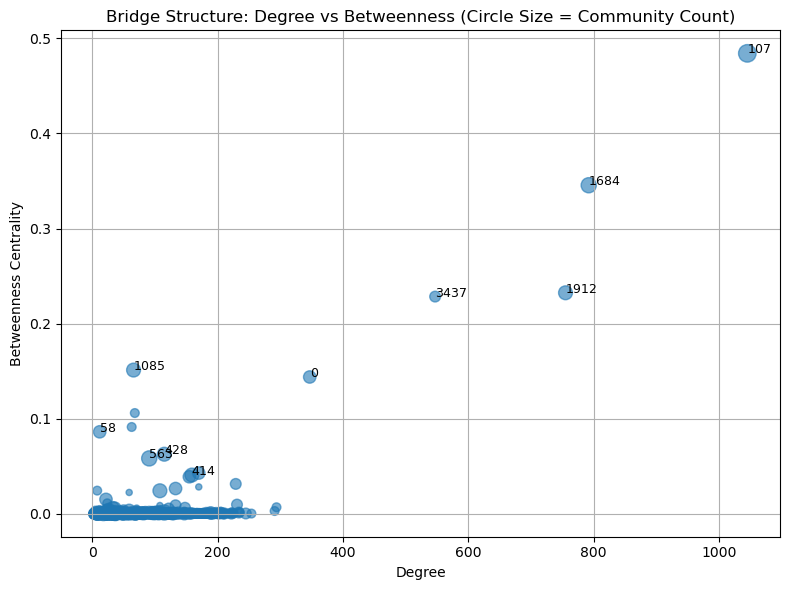

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(df['degree'], df['betweenness'], s=df['neighbor_community_count']*20, alpha=0.6)

# highlight top brokers
for nid in top_brokers_fixed['node'].head(10):
    row = df[df['node']==nid].iloc[0]
    plt.text(row['degree'], row['betweenness'], str(nid), fontsize=9)

plt.xlabel("Degree")
plt.ylabel("Betweenness Centrality")
plt.title("Bridge Structure: Degree vs Betweenness (Circle Size = Community Count)")
plt.grid(True)
plt.tight_layout()
plt.show()


### RQ3 — Hierarchical Structure & Core–Periphery Analysis
Does the network show a core–periphery hierarchy, and what does this imply about authority, 
influence concentration, and information control within a school platform?

Methods: Core–periphery scoring, eigenvector centrality, k-core decomposition.


#### Computing Core–Periphery Model

In [31]:
# Compute k-core numbers
core_numbers = nx.core_number(G)

# Convert to DataFrame for inspection
core_df = pd.DataFrame.from_dict(core_numbers, orient='index', columns=['core'])

# Basic stats
print("Max core index:", core_df['core'].max())
print("\nCore size distribution:")
print(core_df['core'].value_counts().sort_index())

# Extract top-core nodes
top_core_value = core_df['core'].max()
top_core_nodes = core_df[core_df['core'] == top_core_value].index.tolist()

print("\nNumber of nodes in top core:", len(top_core_nodes))
print("Sample of top-core nodes:", top_core_nodes[:20])


Max core index: 115

Core size distribution:
core
1       75
2      108
3      102
4      120
5      134
      ... 
111      4
112      3
113      2
114      7
115    158
Name: count, Length: 96, dtype: int64

Number of nodes in top core: 158
Sample of top-core nodes: [1912, 2543, 2266, 2347, 2542, 2468, 1917, 1918, 1929, 1938, 1943, 1946, 1962, 1966, 1971, 1979, 1983, 1984, 1985, 1986]


#### Visualizing the Core–Periphery Hierarchy

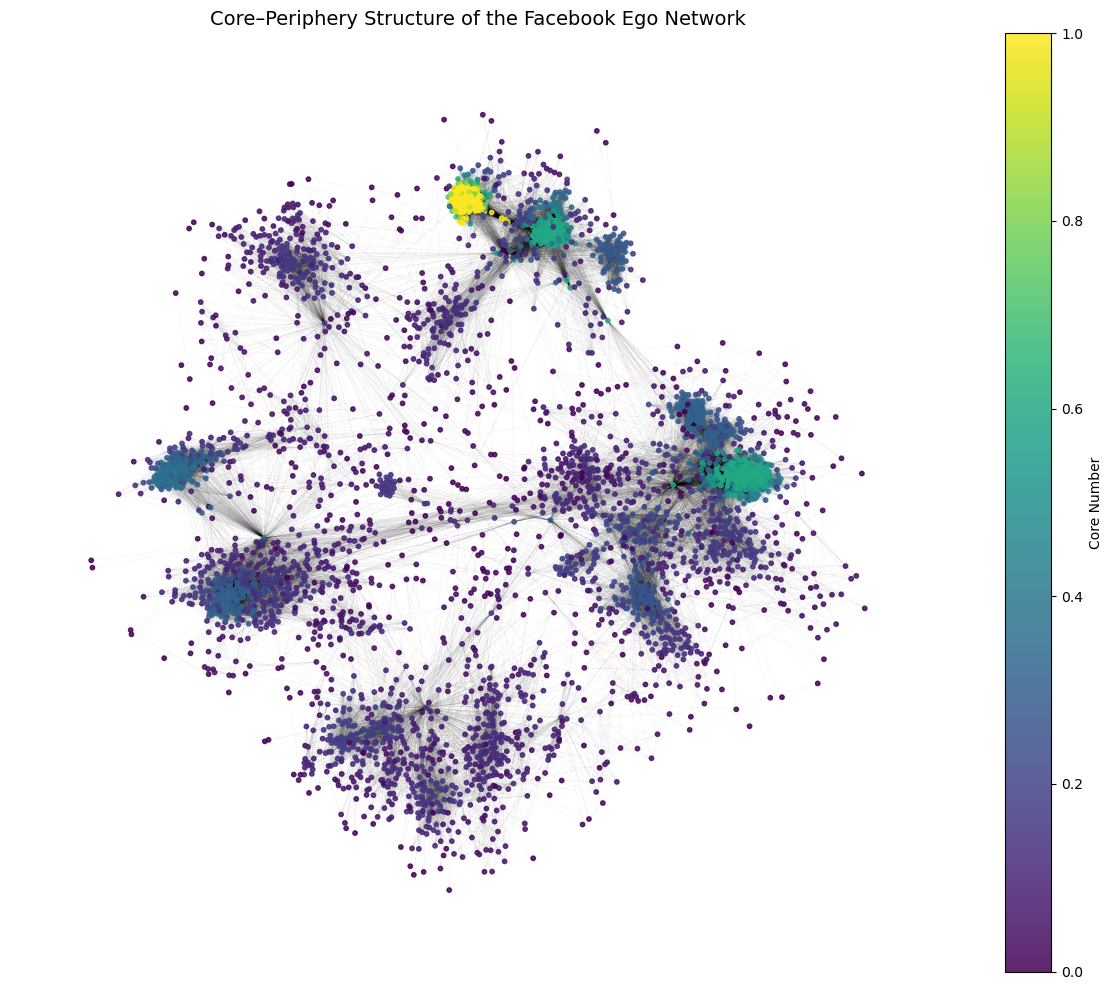

In [33]:
# Normalize core values for color map
core_values = np.array([core_numbers[n] for n in G.nodes()])
norm = (core_values - core_values.min()) / (core_values.max() - core_values.min())

# Compute layout
pos = nx.spring_layout(G, seed=42, k=0.1)

plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=10,
    node_color=norm,
    cmap='viridis',
    alpha=0.85
)

nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.2)

plt.colorbar(nodes, label="Core Number")
plt.title("Core–Periphery Structure of the Facebook Ego Network", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


### RQ4 — Network Resilience & Failure Simulation
How does the network respond to systematic node removal (random vs. targeted), and which nodes 
are most critical for maintaining communication flow across the platform?

Methods: Targeted attack simulation on top-k central nodes, giant component tracking, and robustness curves.


#### Computing Failure Curve (Targeted Attack)

In [35]:
import copy

# Copy graph so we don't disturb the original
G_attack = G.copy()

# Sort nodes by degree (highest first)
big_nodes = sorted(G_attack.degree(), key=lambda x: x[1], reverse=True)
big_nodes = [n for n, d in big_nodes[:200]]  # simulate top 200 removals

lcc_sizes = []
components_count = []

for i, node in enumerate(big_nodes):
    G_attack.remove_node(node)
    if len(G_attack) == 0:
        lcc_sizes.append(0)
        components_count.append(0)
        break

    lcc = max(nx.connected_components(G_attack), key=len)
    lcc_sizes.append(len(lcc))
    components_count.append(nx.number_connected_components(G_attack))

# Convert to array for smoother plotting
lcc_arr = np.array(lcc_sizes)
comp_arr = np.array(components_count)

print("Simulation complete.")
print("LCC size after removing top 200 hubs:", lcc_arr[-1])


Simulation complete.
LCC size after removing top 200 hubs: 3750


#### Visualising failure curves

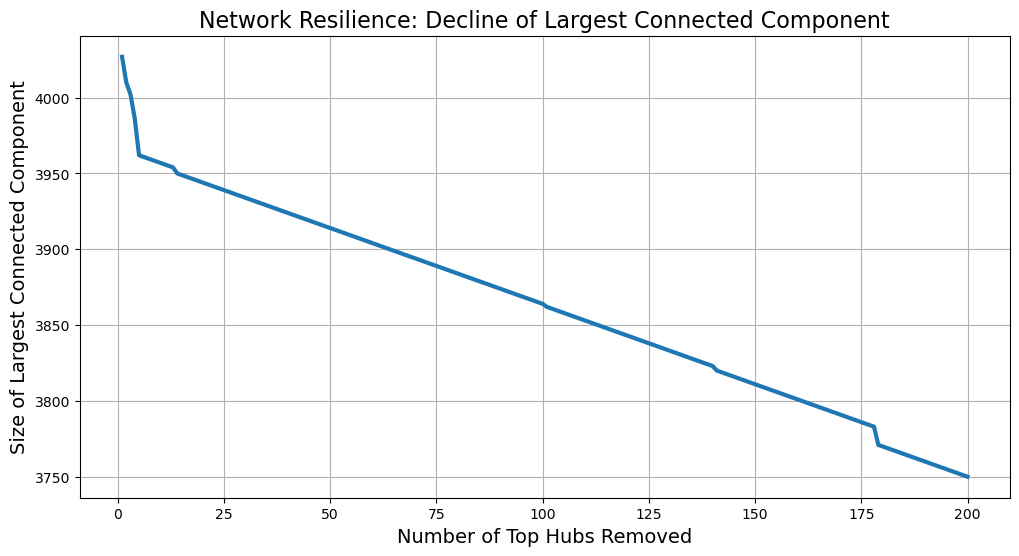

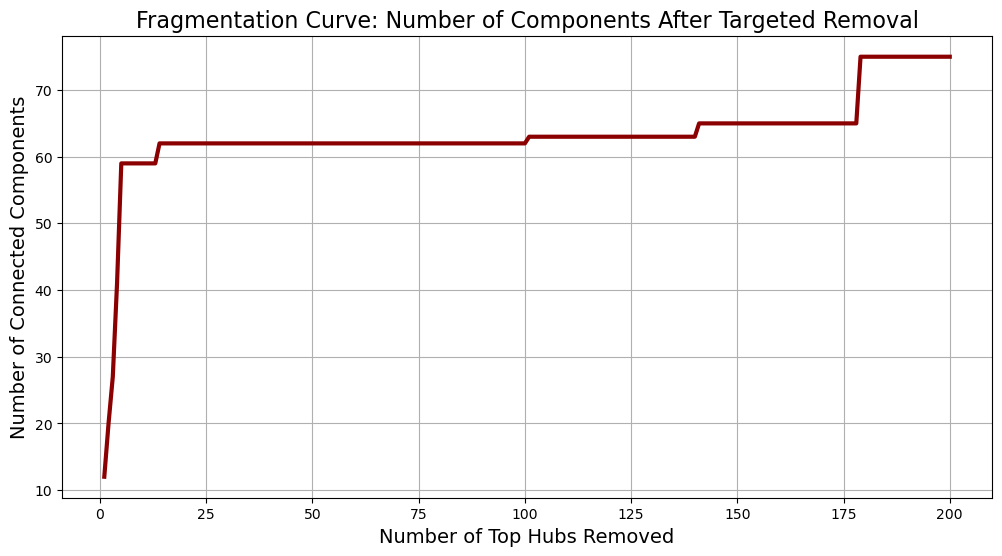

In [37]:
# X-axis: number of removed hubs
x = list(range(1, len(lcc_arr)+1))

plt.figure(figsize=(12,6))
plt.plot(x, lcc_arr, linewidth=3)
plt.title("Network Resilience: Decline of Largest Connected Component", fontsize=16)
plt.xlabel("Number of Top Hubs Removed", fontsize=14)
plt.ylabel("Size of Largest Connected Component", fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(x, comp_arr, color='darkred', linewidth=3)
plt.title("Fragmentation Curve: Number of Components After Targeted Removal", fontsize=16)
plt.xlabel("Number of Top Hubs Removed", fontsize=14)
plt.ylabel("Number of Connected Components", fontsize=14)
plt.grid(True)
plt.show()


### RQ5 — Homophily, Clustering & Triadic Closure
To what extent does the network exhibit homophily, clustering, or triadic closure, 
and what does this reveal about natural group formation (friend groups, study units) within a school community?

Methods: Global & local clustering, triangle counts, assortativity patterns.


#### Computing clustering & triangle metrics

In [39]:
# --- GLOBAL CLUSTERING ---
global_clustering = nx.average_clustering(G_lcc)
print("Global Clustering Coefficient:", global_clustering)

# --- LOCAL CLUSTERING DISTRIBUTION ---
local_clust = nx.clustering(G_lcc)
local_clust_values = list(local_clust.values())
print("\nLocal Clustering Summary:")
print("Mean:", np.mean(local_clust_values))
print("Median:", np.median(local_clust_values))
print("90th percentile:", np.percentile(local_clust_values, 90))
print("Max:", np.max(local_clust_values))

# --- TRIANGLES ---
triangle_counts = nx.triangles(G_lcc)
total_triangles = sum(triangle_counts.values()) // 3
print("\nTotal Triangles in Network:", total_triangles)

# --- DEGREE ASSORTATIVITY ---
degree_assort = nx.degree_assortativity_coefficient(G_lcc)
print("\nDegree Assortativity Coefficient:", degree_assort)

# --- COMMUNITY ASSORTATIVITY ---
# Use previously computed 'comms' dictionary from Louvain
node_comms = [comms[n] for n in G_lcc.nodes()]
comm_assort = nx.attribute_assortativity_coefficient(G_lcc, node_comms)
print("Community Assortativity Coefficient:", comm_assort)


Global Clustering Coefficient: 0.6055467186200876

Local Clustering Summary:
Mean: 0.6055467186200862
Median: 0.6
90th percentile: 0.9021739130434783
Max: 1.0

Total Triangles in Network: 1612010

Degree Assortativity Coefficient: 0.06357722918564943


NameError: name 'comms' is not defined

In [41]:
# --- COMMUNITY ASSORTATIVITY ---

# Attach community IDs to graph as a node attribute
nx.set_node_attributes(G_lcc, partition, "community")

# Compute community assortativity
comm_assort = nx.attribute_assortativity_coefficient(G_lcc, "community")

print("Community Assortativity Coefficient:", comm_assort)


Community Assortativity Coefficient: 0.9556953925744699


### RQ6 — Information Diffusion Potential
How quickly and widely can information propagate across the network, and what is the expected 
speed and depth of message diffusion starting from the ego node or other hubs?

Methods: BFS cascade layers, average shortest path, diameter, diffusion simulation.


#### STEP 1 — Runing BFS from node 0

In [43]:
from collections import Counter

# ---- RQ6 STEP 1: BFS LAYERS FROM NODE 0 ----
source = 0

# Compute shortest path lengths from node 0
distances = nx.single_source_shortest_path_length(G_lcc, source)

# Descriptive stats
max_dist = max(distances.values())
avg_dist = sum(distances.values()) / len(distances)

layer_counts = Counter(distances.values())

print("=== BFS Diffusion Layers ===")
print("Max diffusion depth (diameter from node 0):", max_dist)
print("Average distance from node 0:", round(avg_dist, 3))
print("\nLayer distribution (distance -> number of nodes):")
for d, count in sorted(layer_counts.items()):
    print(f"Distance {d}: {count} nodes")


=== BFS Diffusion Layers ===
Max diffusion depth (diameter from node 0): 6
Average distance from node 0: 2.829

Layer distribution (distance -> number of nodes):
Distance 0: 1 nodes
Distance 1: 347 nodes
Distance 2: 1171 nodes
Distance 3: 1742 nodes
Distance 4: 519 nodes
Distance 5: 117 nodes
Distance 6: 142 nodes


#### Step 2: Computing Global Diameter & Network Efficiency

In [46]:
print("=== GLOBAL SHORTEST PATH METRICS ===")

# Average shortest path length for the whole largest connected component
avg_shortest_path = nx.average_shortest_path_length(G_lcc)
print("Average shortest path length:", round(avg_shortest_path, 4))

# Diameter (longest shortest path)
diameter = nx.diameter(G_lcc)
print("Network diameter:", diameter)

# Global efficiency
def global_efficiency(G):
    n = len(G)
    inv_dist_sum = 0
    for u in G:
        lengths = nx.single_source_shortest_path_length(G, u)
        inv_dist_sum += sum(1 / d for d in lengths.values() if d > 0)
    return inv_dist_sum / (n * (n - 1))

eff = global_efficiency(G_lcc)
print("Global Efficiency:", round(eff, 4))


=== GLOBAL SHORTEST PATH METRICS ===
Average shortest path length: 3.6925
Network diameter: 8
Global Efficiency: 0.3066


#### Step 3: Simulate an Information Cascade

=== CASCADE SIZE PER LAYER ===
Step 0: 1 users reached
Step 1: 347 users reached
Step 2: 1171 users reached
Step 3: 1742 users reached
Step 4: 519 users reached
Step 5: 117 users reached
Step 6: 142 users reached


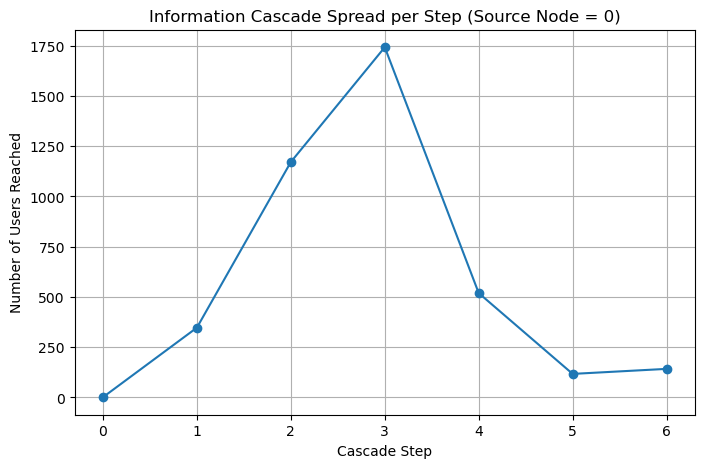

In [49]:
from collections import deque

def simulate_cascade(G, source=0):
    visited = set([source])
    queue = deque([(source, 0)])
    layer_counts = {}

    while queue:
        node, depth = queue.popleft()
        
        if depth not in layer_counts:
            layer_counts[depth] = 0
        layer_counts[depth] += 1
        
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, depth + 1))
    
    return layer_counts

cascade = simulate_cascade(G_lcc, source=0)

print("=== CASCADE SIZE PER LAYER ===")
for depth, count in cascade.items():
    print(f"Step {depth}: {count} users reached")

# Plot cascade curve
plt.figure(figsize=(8,5))
plt.plot(list(cascade.keys()), list(cascade.values()), marker='o')
plt.title("Information Cascade Spread per Step (Source Node = 0)")
plt.xlabel("Cascade Step")
plt.ylabel("Number of Users Reached")
plt.grid(True)
plt.show()
